In [1]:
import pymongo
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm
import talib
import gc
# from Chast import Chast

In [2]:
class Chast:

    def __init__(self, client, db_name='Data'):
        self.client = client
        self.db = client[db_name]
        self._config()
        self.data = dict()
        self.results = dict()
        self.initial_capital = 100000000
        
    def _config(self):
        # 設定繪圖、TQDM讀取條、小數點位數、顯示視窗長度
        pd.options.plotting.backend = "matplotlib"
        tqdm.pandas(desc="progress-bar")
        plt.rcParams['font.family'] = ['Microsoft JhengHei'] # 中文標籤
        plt.rcParams['axes.unicode_minus'] = False # 負號
        pd.set_option('display.max_rows', None)
        pd.set_option('display.float_format', lambda x: '%.3f' % x)
        pd.options.display.float_format = '{:,.4f}'.format

    def _result(self):
        pf = self.results['PROFIT']
        com = self.results['COMMISION']
        self.results['RESULT'] = (pf - com).sum(axis=1).cumsum()

    def _maxdrawdown(self):
        se = self.results['RESULT']
        mdd = 0
        mdd_ = list()
        h = 0
        for i in se:
            if i > h:
                h = i
            mdd = i - h
            mdd_.append(mdd)
        self.results['MDD'] = pd.Series(mdd_, index=se.index, name='MDD')

    def _sharpe_ratio(self, roll: int = 120):
        """
        計算Sharpe ratio
        預設roll 120天=半年
        roll
        """
        pf = self.results['RESULT']
        self.results['SHARPE RATIO'] = (pf-pf.shift(1)).rolling(roll).apply(lambda x: x.mean() / x.std() if x.std() != 0 else 0, raw=True)
    
    def _holding(self):

        bs = self.results['BS']
        if '收盤價' in self.data.keys():
            holding = bs.fillna(0) * self.data['收盤價'].loc[bs.index, bs.columns] * 1000
        else:
            self.get_from_mongo('收盤價')
            holding = bs.fillna(0) * self.data['收盤價'].loc[bs.index, bs.columns] * 1000
        self.results['HOLDING'] = holding

    def _capital(self):
        self.results['CAPITAL NET'] = self.results['CAPITAL'][:-1] + (self.data['收盤價'] * self.results['BS']).sum(axis=1) * 1000 - self.results['COMMISION'].sum(axis=1)


    def get_chart(self):
        keys = self.results

        self._result()
        self._maxdrawdown()
        self._holding()
        self._sharpe_ratio(120)
        self._capital()

        fig ,ax = plt.subplots(6, 1, figsize=(16, 16), gridspec_kw={'height_ratios': [2, 1, 1, 1, 1, 1]})
        
        if 'RESULT' in keys:
            ax[0].plot(self.results['RESULT'][:-1])
            ax[0].set_title(f'累計損益')
            ax[0].grid(True)
            ax[0].yaxis.set_major_formatter('{x:,.0f}')
            ax[0].xaxis.set_minor_locator(mdates.YearLocator())
        if 'MDD' in keys:
            ax[1].plot(self.results['MDD'][:-1], color='orange')
            ax[1].grid(True)
            ax[1].set_title('MaxDrawdown')
            ax[1].yaxis.set_major_formatter('{x:,.0f}')
        if 'BS' in keys:
            ax[2].plot(self.results['BS'].fillna(0).astype(bool).sum(axis=1)[:-1], color='green')
            ax[2].set_title('累計股數')
        if 'HOLDING' in keys:
            ax[3].plot(self.results['HOLDING'].sum(axis=1)[:-1], color='lightgreen')
            ax[3].set_title('累計市值')
            ax[3].yaxis.set_major_formatter('{x:,.0f}')
        if 'SHARPE RATIO' in keys:
            ax[4].plot(self.results['SHARPE RATIO'][:-1], color='lightblue')
            ax[4].grid(True)
            ax[4].set_title('Rolling Sharpe Ratio')
            ax[4].yaxis.set_major_formatter('{x:.3f}')
        if 'CAPITAL' in keys:
            ax[5].plot(self.results['CAPITAL NET'][:-1], color='darkgreen')
            ax[5].grid(True)
            ax[5].set_title('Capital')
            ax[5].yaxis.set_major_formatter('{x:,.0f}')

        fig.tight_layout()
        plt.show()        

    def get_from_mongo(self, e, start: datetime.datetime, end: datetime.datetime):
        """
        e: Element, 表示要在Mongo中抓哪些資料, 可用list包起來好幾項
        start: 開始時間
        end: 結束時間
        """
        collection = self.db.list_collection_names()

        if type(e) != list:
            df = list()
            for c in collection:
                err = list()
                try:
                    se = pd.DataFrame(self.db[c].find({"日期": {'$gt': start, '$lt': end}}, {'_id': 0, '日期': 1, e: 1})).set_index('日期')
                    se.columns = [c]
                    se = se.loc[se.index.dropna()]
                    df.append(se)
                except Exception as exc:
                    err.append((c, exc))
            print(err)
            self.data[e] = pd.concat(df, axis=1).fillna(method='ffill')
        else:
            for ee in e:
                df = list()
                for c in collection:
                    err = list()
                    try:
                        se = pd.DataFrame(self.db[c].find({"日期": {'$gt': start, '$lt': end}}, {'_id': 0, '日期': 1, ee: 1})).set_index('日期')
                        se.columns = [c]
                        se = se.loc[se.index.dropna()]
                        df.append(se)
                    except Exception as exc:
                        err.append((c, exc))
                print(ee, err)
                self.data[ee] = pd.concat(df, axis=1).fillna(method='ffill')
            
    def get_single_from_mongo(self, collection: str, e, start: datetime.datetime, end: datetime.datetime):
        """
        collection: 要在哪個表單抓資料
        e: Element, 表示要在Mongo中抓哪些資料, 可用list包起來好幾項
        start: 開始時間
        end: 結束時間
        """

        if type(e) != list:
            df = list()
            err = list()

            try:
                se = pd.DataFrame(self.db[collection].find({"日期": {'$gt': start, '$lt': end}}, {'_id': 0, '日期': 1, e: 1})).set_index('日期')
                se.columns = [collection]
                se = se.loc[se.index.dropna()]
                df.append(se)
            except Exception as exc:
                err.append((collection, exc))
            print(err)
            if len(df) > 1:
                self.data[collection+'_'+e] = pd.concat(df, axis=1).fillna(method='ffill')
            else:
                self.data[collection+'_'+e] = df[0].fillna(method='ffill')
        else:
            for ee in e:
                df = list()
                err = list()

                try:
                    se = pd.DataFrame(self.db[collection].find({"日期": {'$gt': start, '$lt': end}}, {'_id': 0, '日期': 1, ee: 1})).set_index('日期')
                    se.columns = [collection]
                    se = se.loc[se.index.dropna()]
                    df.append(se)
                except Exception as exc:
                    err.append((collection, exc))
                print(ee, err)
                if len(df) > 1:
                    self.data[collection+'_'+ee] = pd.concat(df, axis=1).fillna(method='ffill')
                else:
                    self.data[collection+'_'+ee] = df[0].fillna(method='ffill')    

    def set_data(self, name: str, df: pd.DataFrame):
        """
        name: 指定data名稱
        data: 放入data
        """
        self.data[name] = df
    
    def set_result(self, pf: pd.DataFrame, bs: pd.DataFrame, com: pd.DataFrame, ep: pd.DataFrame, ed: pd.DataFrame, ca: pd.Series):
        """
        pf: 損益明細
        bs: 部位明細
        com: 費用明細
        ep: 進場價格明細
        ed: 進場時間明細
        ca: 剩餘資金變化
        """
        self.results['PROFIT'] = pf
        self.results['BS'] = bs
        self.results['COMMISION'] = com
        self.results['ENTRY PRICE'] = ep
        self.results['ENTRY DATE'] = ed
        self.results['CAPITAL'] = ca

In [3]:
from IPython.display import display
client = pymongo.MongoClient()
chast = Chast(client, 'Data')
index = Chast(client, 'Index')
display(chast.db['2330'].find_one().keys())


dict_keys(['_id', '整體維持率(%)', '融券維持率(%)', '融資維持率(%)', '融券成本(推估)', '融資成本(推估)', '資買', '資賣', '資現償', '資餘', '資增減', '資限', '券買', '券賣', '券賣金額(千)', '券現償', '券增減', '券餘', '資券相抵', '券資比', '資使用率', '券使用率', '外資買賣超', '外資及陸資(不含外資自營商)買賣超', '外資自營商買賣超', '外資買賣超金額(千)', '外資持股比率(%)', '外資持股成本', '外資尚可投資比率(%)', '自營商買賣超', '自營商買賣超(自行買賣)', '自營商買賣超(避險)', '自營商買賣超金額(千)', '自營商持股比率(%)', '自營商持股成本', '投信買賣超', '投信買賣超金額(千)', '投信持股比率(%)', '投信持股成本', '主力買賣超(張數)', '主力券商淨買超家數', '主力券商淨賣超家數', '買超券商家數', '賣超券商家數', '還原開盤價', '還原最高價', '還原最低價', '還原收盤價', '漲跌', '漲幅(%)', '振幅(%)', '成交量', '成交筆數', '成交金額(千)', '均張', '成交量變動(%)', '均張變動(%)', '股本(百萬)', '總市值(億)', '市值比重(%)', '本益比', '股價淨值比', '本益比(近四季)', '週轉率(%)', '成交值比重(%)', '漲跌停', '開盤價', '最高價', '最低價', '收盤價', '股票代號', '股票名稱', '日期'])

### <font color=orange> 策略步驟 </font>
* 1. 下載需要的資料
* 2. 設定要用到的資料，時間點要對齊收盤
* 3.

##### 1. 下載需要的資料

In [4]:
getting_list = [
    '還原最高價', '還原最低價', '還原收盤價', '收盤價', '成交金額(千)', '資餘', '融資維持率(%)'
]
index_list = [
    '還原最高價', '還原最低價', '還原收盤價', '收盤價', '成交金額(千)','股價淨值比', '融資維持率(%)', '上漲家數', '下跌家數'
]
vix_list = [
    '開盤價', '最高價', '最低價', '收盤價'
]
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2013, 1, 1)
chast.get_from_mongo(getting_list, start, end)
index.get_single_from_mongo('TWA00', index_list, start, end)
index.get_single_from_mongo('VIX', vix_list, start, end)

還原最高價 []
還原最低價 []
還原收盤價 []
收盤價 []
成交金額(千) []
資餘 []
融資維持率(%) []
還原最高價 []
還原最低價 []
還原收盤價 []
收盤價 []
成交金額(千) []
股價淨值比 []
融資維持率(%) []
上漲家數 []
下跌家數 []
開盤價 []
最高價 []
最低價 []
收盤價 []


##### 2. 設定要用到的資料

In [ ]:
# std level preprocess 如果要改買賣乘數就改labels
# labels = [5, 3.5, 2, 1, 0.5]
labels = [10, 7, 4, 2, 1]
std_level = chast.data['還原收盤價'].pct_change().rolling(20).std().div(chast.data['還原收盤價'].pct_change().std(axis=1), axis=0)
for i, v in std_level.iterrows():
    # 去除極端值
    v99 = v.quantile(.95)
    v01 = v.quantile(.05)
    mask_99 = v[v > v99].index
    mask_01 = v[v < v01].index
    std_level.loc[i, mask_99] = v99
    std_level.loc[i, mask_01] = v01
# 把股票按照波動排名，後續用作買的倍率[5, 4, 3, 2, 1]
std_level = std_level.apply(lambda x: pd.cut(x, bins=5, labels=labels) if x.sum() != 0 else [0] * len(x), axis=0)
chast.set_data('std_level', std_level)

In [35]:
def ASharpe():
    twse = index.data['TWA00_收盤價']
    log_twse = np.log(twse) - np.log(twse.shift(25))
    log95 = log_twse.rolling(25).quantile(.95).loc[chast.data['還原收盤價'].index].shift(1)
    log32 = log_twse.rolling(25).quantile(.32).loc[chast.data['還原收盤價'].index].shift(1)
    log_stk = np.log(chast.data['還原收盤價']) - np.log(chast.data['還原收盤價'].shift(25)).replace([np.inf, -np.inf], np.nan)
    # big
    big = log_stk[log_stk.gt(log95.values, axis=0)].rolling(25, min_periods=1).apply(lambda x: np.count_nonzero(~np.isnan(x)) * np.nanmean(x) / 25)#.fillna(0)
    # small
    small = log_stk[log_stk.lt(log32.values, axis=0)].rolling(25, min_periods=1).apply(lambda x: np.count_nonzero(~np.isnan(x)) * np.nanmean(x) / 25)#.fillna(0)
    # # between big and small
    between = log_stk[~(log_stk.gt(log95.values, axis=0) | log_stk.lt(log32.values, axis=0))].rolling(25, min_periods=1).apply(
        lambda x: np.count_nonzero(~np.isnan(x)) * np.nanmean(x) / 25 if np.nanmean(x) > 0 \
            else (-np.count_nonzero(~np.isnan(x)) * np.nanmean(x) / 25 if np.nanmean(x) < 0  else 0)).fillna(0)

    small[small==0] = small.mean().mean()
    diff = (big / small)
    diff[diff > diff.quantile(.95)] = diff.quantile(.95).mean()
    diff[diff < diff.quantile(.05)] = diff.quantile(.05).mean()
    asr = diff.fillna(0) + between
    return asr
asr = ASharpe()


c:\Users\ChastLai\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [20]:
twse = index.data['TWA00_收盤價']
log_twse = np.log(twse) - np.log(twse.shift(25))
log_good = log_twse.rolling(25).quantile(.90)
log_bad = log_twse.rolling(25).quantile(.32)
def ASharpe(se):
    print(se)
    series = se.copy()
    if series.sum() == 0:
        return 0
    print('1')
    series = series.fillna(method='ffill').fillna(method='bfill')
    series = np.log(series) - np.log(series.shift(1))
    print('2')
    good = series[series.ge(log_good.loc[series.index])]
    good = good.mean() * len(good)
    print('3')
    bad = series[series.le(log_bad.loc[series.index])]
    bad = bad.mean() * len(bad)
    print('4')
    median = series[(series.le(log_bad.loc[series.index])) & (series.ge(log_good.loc[series.index]))]
    median = abs(median.mean() * len(median))
    print('5')
    if bad != 0:
        asr = good / bad + median
    else:
        asr = median
    return asr


stock = chast.data['還原收盤價']
#test = twse.iloc[-500:].rolling(5).progress_apply(ASharpe)

In [21]:
stock.iloc[-5:].rolling(5).apply(ASharpe)

日期
2012-12-24   11.6100
2012-12-25   11.7600
2012-12-26   12.0000
2012-12-27   12.0900
2012-12-28   11.9700
dtype: float64
1
2
日期
2012-12-24   19.8900
2012-12-25   20.1900
2012-12-26   20.1100
2012-12-27   20.2600
2012-12-28   20.5000
dtype: float64
1
2
日期
2012-12-24   43.9300
2012-12-25   44.5500
2012-12-26   45.1000
2012-12-27   44.2400
2012-12-28   45.5300
dtype: float64
1
2
日期
2012-12-24   17.7800
2012-12-25   18.1500
2012-12-26   18.1000
2012-12-27   18.0400
2012-12-28   18.1800
dtype: float64
1
2
日期
2012-12-24   10.1300
2012-12-25   10.2100
2012-12-26   10.2900
2012-12-27   10.2500
2012-12-28   10.2500
dtype: float64
1
2
日期
2012-12-24   11.7700
2012-12-25   12.0300
2012-12-26   12.5300
2012-12-27   12.4500
2012-12-28   12.3600
dtype: float64
1
2
日期
2012-12-24   31.9200
2012-12-25   32.3300
2012-12-26   32.1500
2012-12-27   32.3300
2012-12-28   32.2400
dtype: float64
1
2
日期
2012-12-24   6.5700
2012-12-25   6.5900
2012-12-26   6.5900
2012-12-27   6.5900
2012-12-28   6.5200
dtype: f

C:\Users\ChastLai\AppData\Local\Temp\ipykernel_19984\3689427515.py:14: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  good = series[series.ge(log_good.loc[series.index])]


日期
2012-12-24   6.3800
2012-12-25   6.3800
2012-12-26   6.4700
2012-12-27   6.4200
2012-12-28   6.8500
dtype: float64
1
2
日期
2012-12-24   6.7100
2012-12-25   6.7700
2012-12-26   6.7800
2012-12-27   6.7800
2012-12-28   6.8200
dtype: float64
1
2
日期
2012-12-24   18.5800
2012-12-25   19.8700
2012-12-26   19.8700
2012-12-27   19.7000
2012-12-28   19.8300
dtype: float64
1
2
日期
2012-12-24   8.1400
2012-12-25   8.1000
2012-12-26   8.4300
2012-12-27   8.4000
2012-12-28   8.3200
dtype: float64
1
2
日期
2012-12-24   25.3000
2012-12-25   25.6600
2012-12-26   26.3100
2012-12-27   26.4900
2012-12-28   26.3100
dtype: float64
1
2
日期
2012-12-24   30.0200
2012-12-25   29.7100
2012-12-26   29.6500
2012-12-27   29.3400
2012-12-28   29.4100
dtype: float64
1
2
日期
2012-12-24   46.7000
2012-12-25   43.4600
2012-12-26   44.7400
2012-12-27   43.2600
2012-12-28   43.4600
dtype: float64
1
2
日期
2012-12-24   10.7700
2012-12-25   10.9000
2012-12-26   10.8100
2012-12-27   10.9000
2012-12-28   10.9000
dtype: float64
1
2

C:\Users\ChastLai\AppData\Local\Temp\ipykernel_19984\4292341470.py:1: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['1101', '1102', '1103', '1104', '1107', '1108', '1109', '1110', '1201',
       '1203',
       ...
       '9944', '9945', '9946', '9949', '9950', '9951', '9955', '9958', '9960',
       '9962'],
      dtype='object', length=1447)
  stock.iloc[-5:].rolling(5).apply(ASharpe)


,8435,1597,1599
日期,,,
2012-12-24,NaN,NaN,NaN
2012-12-25,NaN,NaN,NaN
2012-12-26,NaN,NaN,NaN
2012-12-27,NaN,NaN,NaN
2012-12-28,NaN,NaN,NaN


In [ ]:
# Trend    
chast.set_data('trend', chast.data['還原收盤價'].apply(func=key, axis=0))
chast.set_data('mean_cross_down', chast.data['還原收盤價'].rolling(20).mean() < chast.data['還原收盤價'].rolling(20).mean().shift(1)) # 月線下彎，作為出場判定之一
# 將需要的值製作放到df中
chast.set_data('arg_vol', chast.data['成交金額(千)'].rolling(5).sum()) # 五日成交金額，作為流動性判斷
# chast.set_data('std level', chast.data['還原收盤價'].pct_change().rolling(20).std())
chast.set_data('l1', chast.data['還原收盤價'] < chast.data['還原最低價'].rolling(20).min().shift(1))
chast.set_data('h1', chast.data['還原收盤價'] > chast.data['還原最高價'].rolling(20).max().shift(1))
chast.set_data('bias', ((chast.data['還原收盤價'] - chast.data['還原收盤價'].rolling(20).mean()) / chast.data['還原收盤價'].rolling(20).std()).replace([np.inf, -np.inf], 0))
# 用近期SHARPE RATIO選股
chast.set_data('Sharpe Ratio', (chast.data['還原收盤價'].pct_change().rolling(20).mean() / \
    chast.data['還原收盤價'].pct_change().rolling(20).std()).replace([np.inf, -np.inf], 0))

In [ ]:
# 總記憶體用量
memory = [i.memory_usage().sum() / (1024**2) for i in chast.data.values()]
print('總RAM用量為 {:.2f} MB'.format(sum(memory)))

總RAM用量為 235.51 MB


In [ ]:
# 檢查資料貼合程度
for k, v in chast.data.items():
    print(f'資料 {k} Shape: {v.shape}')

資料 還原最高價 Shape: (1743, 1531)
資料 還原最低價 Shape: (1743, 1531)
資料 還原收盤價 Shape: (1743, 1531)
資料 收盤價 Shape: (1743, 1531)
資料 成交金額(千) Shape: (1743, 1531)
資料 資餘 Shape: (1743, 1531)
資料 融資維持率(%) Shape: (1743, 1531)
資料 std_level Shape: (1743, 1531)
資料 trend Shape: (1743, 1531)
資料 arg_vol Shape: (1743, 1531)
資料 l1 Shape: (1743, 1531)
資料 h1 Shape: (1743, 1531)
資料 bias Shape: (1743, 1531)
資料 Sharpe Ratio Shape: (1743, 1531)
資料 mean_cross_down Shape: (1743, 1531)


# <font color=yellow> 回測開始 </font>

In [ ]:
# 先跑一個我現在有什麼資料，方便後續操作
print(chast.data.keys())

dict_keys(['還原最高價', '還原最低價', '還原收盤價', '收盤價', '成交金額(千)', '資餘', '融資維持率(%)', 'std_level', 'trend', 'arg_vol', 'l1', 'h1', 'bias', 'Sharpe Ratio', 'mean_cross_down'])


10  系列開始 ----------------------------------------------------------------
每單位 375000 上限 50000000


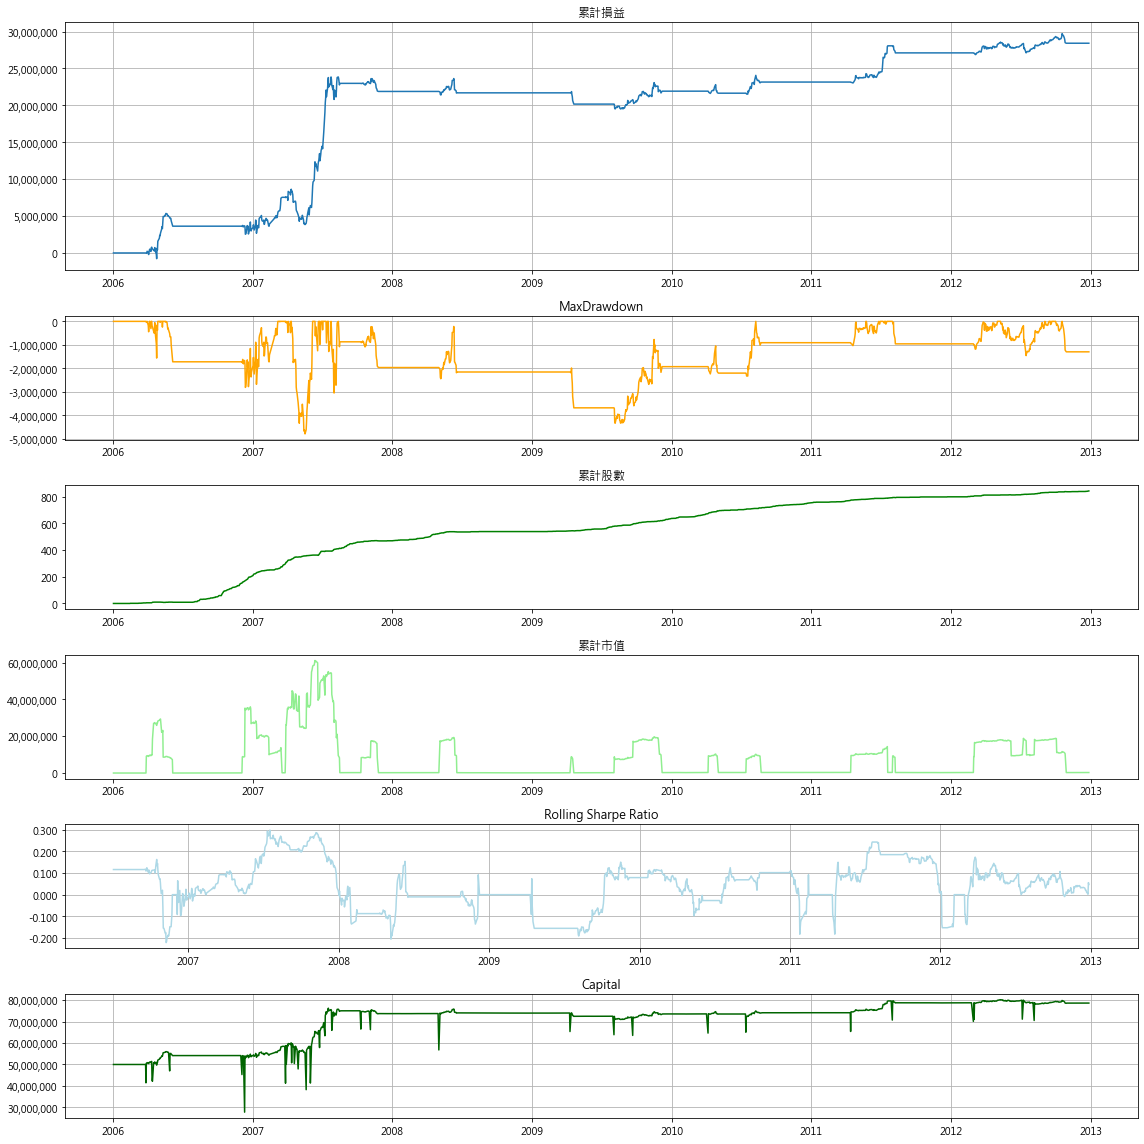








7  系列開始 ----------------------------------------------------------------
每單位 375000 上限 50000000


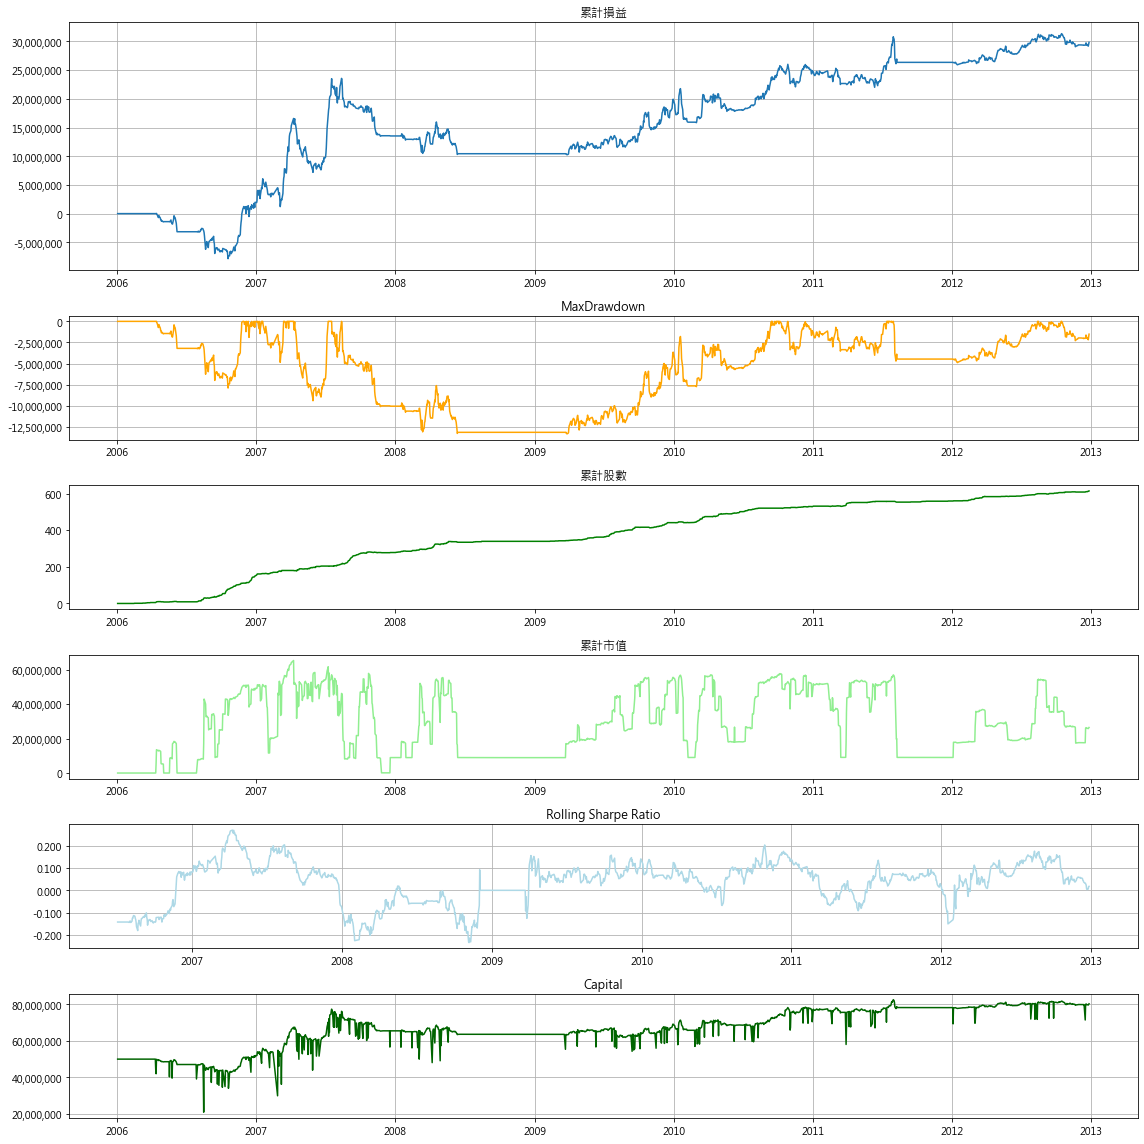








4  系列開始 ----------------------------------------------------------------
每單位 375000 上限 50000000


In [ ]:
# 用還原收盤價當基準
def backtesting(per_capital: int = 250000, total_capital: int = 100000000):
    f_idx, f_col = chast.data['還原收盤價'].index, chast.data['還原收盤價'].columns
    # 製作空表格，用於計算時存值，最後set回去五個底線dataframe
    def make_df(idx, col):
        return pd.DataFrame(index=idx, columns=col)

    bs = make_df(f_idx, f_col).fillna(0)
    com_ = make_df(f_idx, f_col).fillna(0)
    pf_ = make_df(f_idx, f_col).fillna(0)
    # ep_: entryprice, 空單時用0當initail
    ep_ = make_df(f_idx, f_col).fillna(99999)
    ed_ = make_df(f_idx, f_col).fillna(f_idx[0])
    bs_ = make_df(f_idx, f_col).fillna(0)
    eh_ = make_df(f_idx, f_col).fillna(0)
    el_ = make_df(f_idx, f_col).fillna(99999)

    # 存前一根K的時間
    idx1 = f_idx[0]
    # 還原收盤價與收盤價的轉換
    transform = chast.data['收盤價'] / chast.data['還原收盤價']
    # 資金設定 1 億
    # per_capital = 250000
    # total_capital = 100000000
    capital = pd.Series([total_capital] * len(f_idx), index=f_idx)
    for idx, row in chast.data['還原收盤價'].iterrows():
        # 用at取代loc，聽說更快
        for col in row.index:
            bs_.at[idx, col] = bs.at[idx1, col]
            bs.at[idx, col] = bs.at[idx1, col]
            ep_.at[idx, col] = ep_.at[idx1, col]
            eh_.at[idx, col] = eh_.at[idx1, col]
        capital[idx] = capital[idx1]

        # 進場條件1
        entry_mask1 = (bs.loc[idx, :] == 0) &\
            (chast.data['arg_vol'].loc[idx, :] > 50000) & \
            (chast.data['mean_cross_down'].loc[idx, :] == False) & \
            chast.data['bias'].loc[idx, :].between(0.5, 2) &\
            (chast.data['trend'].loc[idx, :] == 'up') & \
            (chast.data['trend'].loc[idx1, :] != 'up')
            #chast.data['agg_fib'].loc[idx, :] & \
            #chast.data['agg_fir'].loc[idx, :] & \
            #chast.data['agg_v'].loc[idx, :] & \
        # 進場條件2
        entry_mask2 = (bs.loc[idx, : ] == 0) &\
            (chast.data['arg_vol'].loc[idx, :] > 50000) & \
            (chast.data['mean_cross_down'].loc[idx, :] == False) & \
            chast.data['bias'].loc[idx, :].between(0.5, 2) &\
            (chast.data['trend'].loc[idx, :] == 'up') & \
            (chast.data['trend'].loc[idx1, :] == 'up') & \
            (chast.data['h1'].loc[idx, :])
        
        # 出場條件
        exit_mask = (bs_.loc[idx, :] >= 1) & \
            ((chast.data['mean_cross_down'].loc[idx, :] & \
            chast.data['l1'].loc[idx, :]) | \
            ((chast.data['還原收盤價'].loc[idx, :] > ep_.loc[idx, :] * 1.5) | \
            (chast.data['還原收盤價'].loc[idx, :] < eh_.loc[idx, :] * 0.9)))

        # 當有商品滿足進場條件時執行  
        if entry_mask1.sum() > 0:
            # 用Sharpe Ratio排序股票，作為買進順序
            for col in chast.data['Sharpe Ratio'].loc[idx, row[entry_mask1].index].rank(ascending=False).sort_values().index:

                # 買進的股數
                contract = np.floor(per_capital / chast.data['收盤價'].at[idx, col] / 1000) * chast.data['std_level'].at[idx, col]
                # 買進花多少錢
                money = contract * 1000 * chast.data['收盤價'].at[idx, col]
                # 目前持倉多少錢
                holding = ((chast.data['收盤價'].loc[idx, :] * bs.loc[idx, :]) * 1000).sum()
                # 若資金足夠、持倉市值沒太大才買進
                if (capital.at[idx] > money) & (holding < total_capital) & (contract >= 1):
                    bs.at[idx, col] = contract
                    capital.at[idx] -= money
                    # if col == '2706':
                    #     print(idx, col, ' 進場1 ', \
                    #         (bs.loc[idx, col] == 0) , \
                    #         (chast.data['arg_vol'].loc[idx, col] > 50000) , \
                    #         (chast.data['mean_cross_down'].loc[idx, col] == False) , \
                    #         chast.data['bias'].loc[idx, col] ,\
                    #         (chast.data['trend'].loc[idx, col] == 'up') , \
                    #         (chast.data['trend'].loc[idx1, col] != 'up'))
                else:
                    pass
                    # print(f'No Money to Buy 2: {col}  capital: {capital.at[idx]} Need {money}')
                
        if entry_mask2.sum() > 0:
            for col in chast.data['Sharpe Ratio'].loc[idx, row[entry_mask2].index].rank(ascending=False).sort_values().index:

                #print(idx, col, ' 進場2')
                contract = np.floor(per_capital / chast.data['收盤價'].at[idx, col] / 1000) * chast.data['std_level'].at[idx, col]
                money = contract * 1000 * chast.data['收盤價'].at[idx, col]
                holding = ((chast.data['收盤價'].loc[idx, :] * bs.loc[idx, :]) * 1000).sum()
                if (capital.at[idx] > money) & (holding < total_capital) & (contract >= 1):
                    bs.at[idx, col] = contract
                    capital.at[idx] -= money
                    # if col == '2706':
                    #     print(idx, col, ' 進場2 ', \
                    #         (bs.loc[idx, col] == 0) , \
                    #         (chast.data['arg_vol'].loc[idx, col] > 50000) , \
                    #         (chast.data['mean_cross_down'].loc[idx, col] == False) , \
                    #         chast.data['bias'].loc[idx, col] ,\
                    #         (chast.data['trend'].loc[idx, col] == 'up') , \
                    #         (chast.data['trend'].loc[idx1, col] != 'up'), \
                    #         (chast.data['h1'].loc[idx, col]))
                    pass
                    # print(f'No Money to Buy 2: {col}  capital: {capital.at[idx]} Need {money}')
        # 當有商品滿足出場條件時執行
        if exit_mask.sum() > 0:
            for col in row[exit_mask].index:
                # if col == '2706':
                #     print(idx, col, ' 出場', bs_.loc[idx, col] >= 1, chast.data['mean_cross_down'].loc[idx, col], \
                #         chast.data['l1'].loc[idx, col], \
                #         chast.data['還原收盤價'].loc[idx, col] > ep_.loc[idx, col] * 1.5, \
                #         chast.data['還原收盤價'].loc[idx, col] < eh_.loc[idx, col] * 0.9)
                
                bs.at[idx, col] = 0
                
        for col in row.index:
            # 進場
            if (bs_.at[idx, col] >= 1) & (bs_.at[idx1, col] == 0):
                com_.at[idx, col] = np.round((0.001425 + 0.003) * bs_.at[idx, col] * 1000 * chast.data['收盤價'].at[idx, col], 2)
                ep_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                eh_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
                ed_.at[idx, col] = idx
            # 出場   
            if (bs_.at[idx, col] == 0) & (bs_.at[idx1, col] >= 1):
                com_.at[idx, col] = np.round((0.001425 + 0.003 +0.003) * bs_.at[idx1, col] * 1000 * chast.data['收盤價'].at[idx, col], 2)
                money = np.round(bs_.at[idx1, col] * 1000 * chast.data['收盤價'].at[idx, col], 2)
                capital.at[idx] += money
                # print(f'出場 capital 剩餘: {capital.at[idx]} 增加資金: {money}')
            
            # 損益計算
            if (bs_.at[idx1, col] >= 1):
                pf_.at[idx, col] = np.round((chast.data['還原收盤價'].at[idx, col] - chast.data['還原收盤價'].at[idx1, col]) * transform.at[idx1, col] * bs_.at[idx1, col] * 1000, 2)
                if chast.data['還原收盤價'].at[idx, col] > eh_.at[idx, col]:
                    eh_.at[idx, col] = chast.data['還原收盤價'].at[idx, col]
        
        idx1 = idx
    chast.set_result(pf_, bs_, com_, ep_, ed_, capital)
    chast.get_chart()


# 最佳化
# std level preprocess 如果要改買賣乘數就改labels
# labels = [5, 3.5, 2, 1, 0.5]
labels_test = {
    #'10到1': [10, 7, 4, 2, 1],
    '10': [24, 0.001, 0.0011, 0.0012, 0.0013],
    '7': [0.001, 24, 0.0011, 0.0012, 0.0014],
    '4': [0.001, 0.0011, 24, 0.0013, 0.0014],
    '2': [0.001, 0.0011, 0.0012, 24, 0.0014],
    '1': [0.001, 0.0011, 0.0012, 0.0013, 24]
    #'2的倍數層': [16, 8, 4, 2, 1]
}
for k, labels in labels_test.items():
    std_level = chast.data['還原收盤價'].pct_change().rolling(20).std().div(chast.data['還原收盤價'].pct_change().std(axis=1), axis=0)
    for i, v in std_level.iterrows():
        # 去除極端值
        v99 = v.quantile(.95)
        v01 = v.quantile(.05)
        mask_99 = v[v > v99].index
        mask_01 = v[v < v01].index
        std_level.loc[i, mask_99] = v99
        std_level.loc[i, mask_01] = v01
    # 把股票按照波動排名，後續用作買的倍率[5, 4, 3, 2, 1]
    std_level = std_level.apply(lambda x: pd.cut(x, bins=5, labels=labels) if x.sum() != 0 else [0] * len(x), axis=0)
    chast.set_data('std_level', std_level)
    print(k, ' 系列開始 ----------------------------------------------------------------')
    for per in [375000]:
        for limit in [50000000]:
            print(f'每單位 {per} 上限 {limit}')
            backtesting(per, limit)
            print('\n\n\n\n\n\n')
            

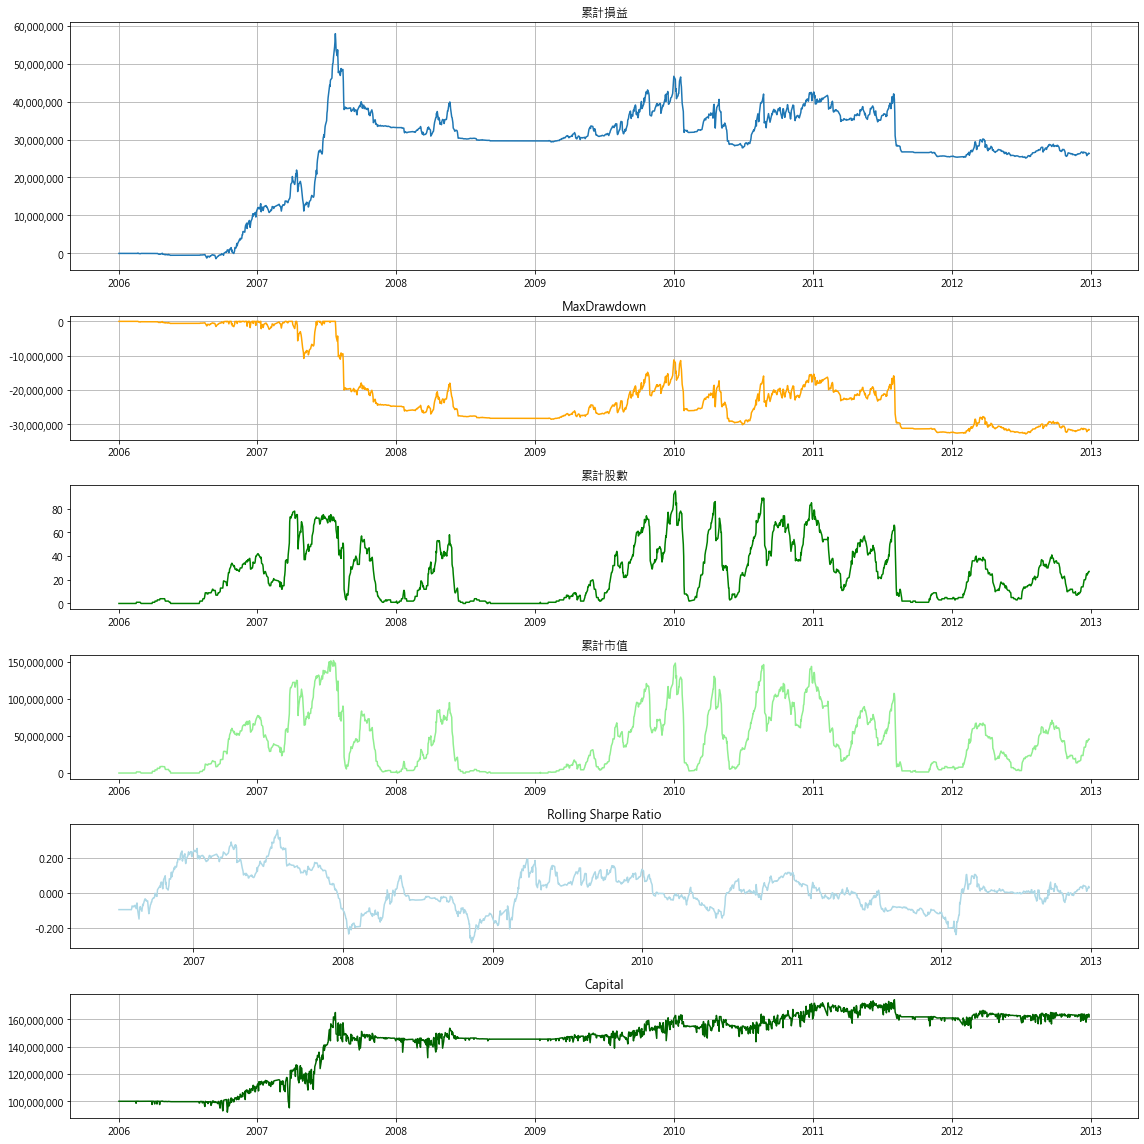

In [ ]:
chast.set_result(pf_, bs_, com_, ep_, ed_, capital)
chast.get_chart()

In [ ]:
chast.data['std_level'].loc['2008', '2706']

日期
2008-01-02      4
2008-01-03      3
2008-01-04      3
2008-01-07      4
2008-01-08      4
2008-01-09      3
2008-01-10      2
2008-01-11      2
2008-01-14      3
2008-01-15      3
2008-01-16      3
2008-01-17      3
2008-01-18      3
2008-01-21      3
2008-01-22      2
2008-01-23      3
2008-01-24      4
2008-01-25    NaN
2008-01-28      2
2008-01-29      2
2008-01-30      3
2008-01-31    NaN
2008-02-01      2
2008-02-12      3
2008-02-13      2
2008-02-14      2
2008-02-15      2
2008-02-18      2
2008-02-19      2
2008-02-20      4
2008-02-21    NaN
2008-02-22      2
2008-02-25      3
2008-02-26      4
2008-02-27    NaN
2008-02-29      4
2008-03-03    NaN
2008-03-04      4
2008-03-05      4
2008-03-06    NaN
2008-03-07      4
2008-03-10      3
2008-03-11      2
2008-03-12    NaN
2008-03-13      2
2008-03-14      2
2008-03-17      4
2008-03-18    NaN
2008-03-19      2
2008-03-20      2
2008-03-21      2
2008-03-24      3
2008-03-25      3
2008-03-26      3
2008-03-27      2
2008-03

In [ ]:
chast.results['PROFIT'].groupby(pd.Grouper(freq='1y')).sum().sum(axis=1)

日期
2017-12-31    5,371,429.0000
2018-12-31    7,394,091.2000
2019-12-31   21,924,741.6400
2020-12-31   44,417,874.3000
2021-12-31   41,296,100.7200
2022-12-31   -4,196,934.5400
Freq: A-DEC, dtype: float64

# 測試環節，雖然測了還是看不懂為什麼

In [ ]:
bs_.loc['2008-01':'2008-05', '2706']
idx1 = '2008-03-05'
idx = '2008-03-06'
name = '2706'
print('Entry 1')
print(bs.loc[idx, name])
print(chast.data['arg_vol'].loc[idx, name])
print(chast.data['mean_cross_down'].loc[idx, name])
print(chast.data['agg_fib'].loc[idx, name])
print(chast.data['agg_fir'].loc[idx, name])
print(chast.data['agg_v'].loc[idx, name])
print(chast.data['bias'].loc[idx, name])
print(chast.data['trend'].loc[idx, name])
print(chast.data['trend'].loc[idx1, name], '\n')
print('Entry 2')
print(chast.data['還原收盤價'].loc[idx, name] > chast.data['max'].loc[idx, name], '\n')
print('Exit')
print(bs_.loc[idx, name])
print(chast.data['mean_cross_down'].loc[idx, name])
print(chast.data['l1'].loc[idx, name])
print(chast.data['還原收盤價'].loc[idx, name] > ep_.loc[idx, name] * 1.5)
print(chast.data['還原收盤價'].loc[idx, name] < eh_.loc[idx, name] * 0.9)

Entry 1
0
192996.0
False
False
False
False
1.4667921185559287
up
up 

Entry 2
False 

Exit
48
False
False
False
False


In [ ]:
((chast.data['mean_cross_down'].loc[idx, name] & \
chast.data['l1'].loc[idx, name]) | \
((chast.data['還原收盤價'].loc[idx, name] > ep_.loc[idx, name] * 1.5) | \
(chast.data['還原收盤價'].loc[idx, name] < eh_.loc[idx, name] * 0.9)))

False

In [ ]:
bs_.loc['2008-01':'2008-05', '2706']

日期
2008-01-02     0
2008-01-03     0
2008-01-04     0
2008-01-07     0
2008-01-08     0
2008-01-09     0
2008-01-10     0
2008-01-11     0
2008-01-14     0
2008-01-15     0
2008-01-16     0
2008-01-17     0
2008-01-18     0
2008-01-21     0
2008-01-22     0
2008-01-23     0
2008-01-24     0
2008-01-25     0
2008-01-28     0
2008-01-29     0
2008-01-30     0
2008-01-31     0
2008-02-01     0
2008-02-12     0
2008-02-13     0
2008-02-14     0
2008-02-15     0
2008-02-18     0
2008-02-19     0
2008-02-20     0
2008-02-21     0
2008-02-22     0
2008-02-25     0
2008-02-26     0
2008-02-27     0
2008-02-29     0
2008-03-03     0
2008-03-04     0
2008-03-05     0
2008-03-06    48
2008-03-07     0
2008-03-10     0
2008-03-11     0
2008-03-12     0
2008-03-13     0
2008-03-14     0
2008-03-17     0
2008-03-18     0
2008-03-19     0
2008-03-20     0
2008-03-21     0
2008-03-24     0
2008-03-25    33
2008-03-26    33
2008-03-27    33
2008-03-28    33
2008-03-31    33
2008-04-01    33
2008-04-02 

In [ ]:
bs_.at[idx, col]

0

In [ ]:
bs.at[idx1, col] = 1

In [ ]:
bs_.at[idx, col] = bs.at[idx1, col]
print(bs_.at[idx, col], bs.at[idx1, col])
bs.at[idx, col] = 2
print(bs_.at[idx, col], bs.at[idx, col])

1 1
1 2
